Liz Rightmire

N1 Health Challenge

November 2024

In [557]:
import pandas as pd
import numpy as np
import matplotlib
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
import matplotlib.pyplot as plt
from shapely.wkt import loads

# Data

In [558]:
places = pd.read_csv("Datasets/500cities/CDC_Places.csv")
access = pd.read_csv("Datasets/FoodEnvironmentAtlas/access.csv")
insecurity = pd.read_csv("Datasets/FoodEnvironmentAtlas/insecurity.csv")

stores = pd.read_csv("Datasets/FoodEnvironmentAtlas/stores.csv")
stores['Food Stores per 1,000 people'] = stores['GROCPTH16'] + stores['SUPERCPTH16'] + stores['SPECSPTH16']

/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_39004/1472687036.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  places = pd.read_csv("Datasets/500cities/CDC_Places.csv")


In [559]:
# health datasets
diabetes = places[(places['MeasureId'] == 'DIABETES') & (places['Data_Value_Type'] == 'Age-adjusted prevalence')]
diabetes_filtered = diabetes[['StateDesc', 'LocationName', 'LocationID', 'Data_Value', 'Geolocation']]
diabetes_filtered.rename(columns = {'Data_Value' : 'Diabetes Rate (%)'}, inplace=True)
diabetes_filtered = diabetes_filtered.dropna(subset=['Geolocation'])
diabetes_filtered

obesity = places[(places['MeasureId'] == 'OBESITY') & (places['Data_Value_Type'] == 'Age-adjusted prevalence')]
obesity_filtered = obesity[['LocationID', 'Data_Value']]
obesity_filtered.rename(columns = {'Data_Value' : 'Obesity Rate (%)'}, inplace=True)
#obesity_filtered = obesity_filtered.dropna(subset=['Geolocation'])

health_merged = pd.merge(diabetes_filtered,
                         obesity_filtered,
                         how = "inner",
                         on = "LocationID"
                         )

# Clean up FIPS code -- append 0s if not 5 digits in length
#health_merged['LocationID'] = health_merged['LocationID'].apply(lambda x: f"0{x}" if len(str(x)) == 4 else str(x))
health_merged.rename(columns = {'LocationID' : 'FIPS', 
                                'StateDesc' : 'State',
                                'LocationName' : 'County'
                                }, inplace=True)

# Convert Geolocation to geometry if stored as WKT strings
health_merged['geometry'] = health_merged['Geolocation'].apply(loads)

health_merged.head()

/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_39004/985492354.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes_filtered.rename(columns = {'Data_Value' : 'Diabetes Rate (%)'}, inplace=True)
/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_39004/985492354.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obesity_filtered.rename(columns = {'Data_Value' : 'Obesity Rate (%)'}, inplace=True)


,State,County,FIPS,Diabetes Rate (%),Geolocation,Obesity Rate (%),geometry
0,Alaska,Skagway,2230,8.0,POINT (-135.336028290736 59.5592737178809),33.0,POINT (-135.336028290736 59.5592737178809)
1,Alaska,Yukon-Koyukuk,2290,13.4,POINT (-151.390098989755 65.5085661031514),39.5,POINT (-151.390098989755 65.5085661031514)
2,Arkansas,Clark,5019,14.3,POINT (-93.1767308539705 34.0510757211807),40.4,POINT (-93.1767308539705 34.0510757211807)
3,California,Alpine,6003,8.8,POINT (-119.820667930537 38.5974751291386),29.9,POINT (-119.820667930537 38.5974751291386)
4,Alabama,Pike,1109,13.7,POINT (-85.9407627085231 31.8027535253528),40.6,POINT (-85.9407627085231 31.8027535253528)


In [560]:
# Food Atlas Merge
atlas_merged = pd.merge(access[["FIPS", "LACCESS_LOWI15", "LACCESS_HHNV15"]], 
                        stores[["FIPS", "Food Stores per 1,000 people"]],
                       on= "FIPS", 
                       how="inner")

# Rename specific columns
atlas_merged = atlas_merged.rename(columns={'LACCESS_LOWI15': 'Low income & low access to store (2015, count)',
                                            'LACCESS_HHNV15' : 'Households with no car & low access to store, (2015, count)',
                                            })

atlas_merged.head()

,FIPS,"Low income & low access to store (2015, count)","Households with no car & low access to store, (2015, count)","Food Stores per 1,000 people"
0,1001,6543.676824,677.672769,0.090452
1,1003,9886.831137,1394.162766,0.303601
2,1005,2948.790251,425.144927,0.271592
3,1007,596.162829,224.388125,0.265100
4,1009,1650.959482,719.931444,0.104235


In [561]:
# final merge
all_data = pd.merge(health_merged, 
                    atlas_merged,
                    on= "FIPS", 
                    how="inner")

all_data.head()

,State,County,FIPS,Diabetes Rate (%),Geolocation,Obesity Rate (%),geometry,"Low income & low access to store (2015, count)","Households with no car & low access to store, (2015, count)","Food Stores per 1,000 people"
0,Alaska,Skagway,2230,8.0,POINT (-135.336028290736 59.5592737178809),33.0,POINT (-135.336028290736 59.5592737178809),0.488926,2.503659,0.000000
1,Alaska,Yukon-Koyukuk,2290,13.4,POINT (-151.390098989755 65.5085661031514),39.5,POINT (-151.390098989755 65.5085661031514),2779.799148,1116.944260,1.662971
2,Arkansas,Clark,5019,14.3,POINT (-93.1767308539705 34.0510757211807),40.4,POINT (-93.1767308539705 34.0510757211807),4933.730696,314.650723,0.133038
3,California,Alpine,6003,8.8,POINT (-119.820667930537 38.5974751291386),29.9,POINT (-119.820667930537 38.5974751291386),146.579098,9.321428,0.000000
4,Alabama,Pike,1109,13.7,POINT (-85.9407627085231 31.8027535253528),40.6,POINT (-85.9407627085231 31.8027535253528),2074.066321,563.044138,0.240855


# Health Map

In [562]:
# Convert df to GeoDataFrame
gdf = gpd.GeoDataFrame(all_data, geometry='geometry')

# Ensure the CRS is set (e.g., EPSG:4326 for lat/lon)
gdf.set_crs("EPSG:4326", inplace=True)

,State,County,FIPS,Diabetes Rate (%),Geolocation,Obesity Rate (%),geometry,"Low income & low access to store (2015, count)","Households with no car & low access to store, (2015, count)","Food Stores per 1,000 people"
0,Alaska,Skagway,2230,8.0,POINT (-135.336028290736 59.5592737178809),33.0,POINT (-135.33603 59.55927),0.488926,2.503659,0.000000
1,Alaska,Yukon-Koyukuk,2290,13.4,POINT (-151.390098989755 65.5085661031514),39.5,POINT (-151.3901 65.50857),2779.799148,1116.944260,1.662971
2,Arkansas,Clark,5019,14.3,POINT (-93.1767308539705 34.0510757211807),40.4,POINT (-93.17673 34.05108),4933.730696,314.650723,0.133038
3,California,Alpine,6003,8.8,POINT (-119.820667930537 38.5974751291386),29.9,POINT (-119.82067 38.59748),146.579098,9.321428,0.000000
4,Alabama,Pike,1109,13.7,POINT (-85.9407627085231 31.8027535253528),40.6,POINT (-85.94076 31.80275),2074.066321,563.044138,0.240855
...,...,...,...,...,...,...,...,...,...,...
3126,Wisconsin,Waushara,55137,9.8,POINT (-89.2429754089233 44.1131612071157),41.8,POINT (-89.24298 44.11316),113.752167,417.026336,0.372949
3127,Wyoming,Sweetwater,56037,9.4,POINT (-108.879886957441 41.6596981373813),36.3,POINT (-108.87989 41.6597),4750.905615,359.608360,0.135608
3128,Wisconsin,Chippewa,55017,8.4,POINT (-91.2799726300936 45.0694319590576),40.0,POINT (-91.27997 45.06943),3154.358722,571.594721,0.204509
3129,Wisconsin,Oneida,55085,8.3,POINT (-89.5218417475047 45.7055064731892),38.5,POINT (-89.52184 45.70551),1101.222030,308.121696,0.593656


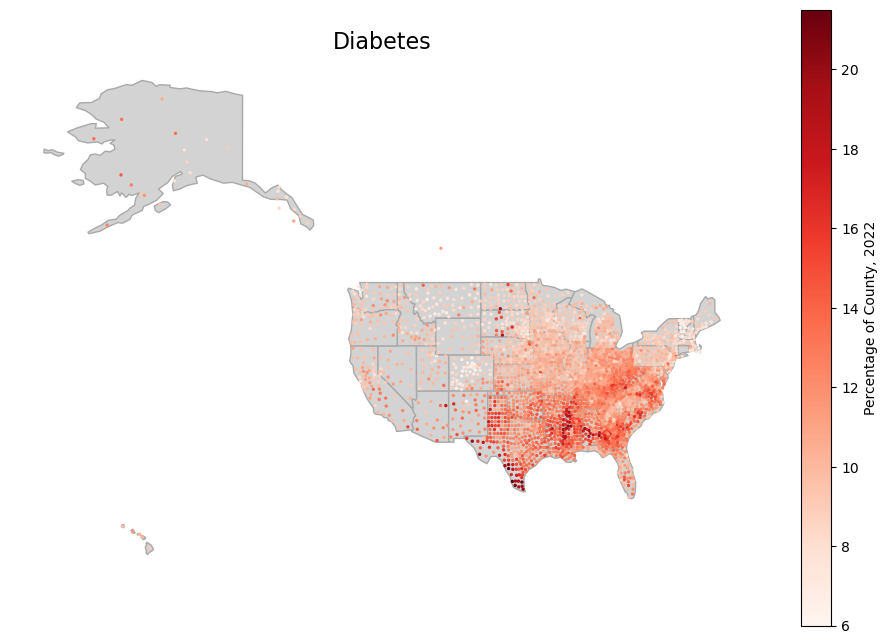

In [563]:
# Load a basemap (e.g., USA states)
states = gpd.read_file("states/states.shp")

# Ensure the CRS matches
states = states.to_crs(gdf.crs)

# Plot the basemap
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
states.plot(ax=ax, color='lightgray', edgecolor='darkgrey')  # Plot state boundaries

# Overlay the points
gdf.plot(
    column='Diabetes Rate (%)',
    cmap='Reds',
    legend=True,
    markersize=2,
    legend_kwds={'label': 'Percentage of County, 2022', 'orientation': 'vertical'},
    ax=ax
)

# Add title and styling
ax.set_title("Diabetes", fontsize=16)
ax.axis('off')
plt.show()

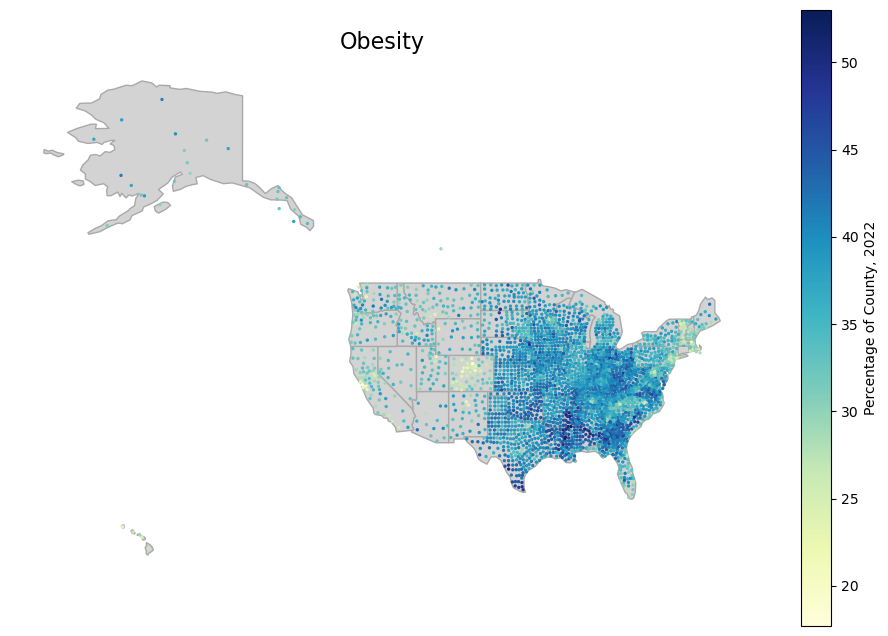

In [564]:
# Plot the basemap
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
states.plot(ax=ax, color='lightgray', edgecolor='darkgrey')

# Overlay the points
gdf.plot(
    column='Obesity Rate (%)',
    cmap='YlGnBu',
    legend=True,
    markersize=2,
    legend_kwds={'label': 'Percentage of County, 2022', 'orientation': 'vertical'},
    ax=ax
)

# Add title and styling
ax.set_title("Obesity", fontsize=16)
ax.axis('off')
plt.show()

# Priority List

In [565]:
# Sort the DataFrame by 'food_insec' in descending order and get the top 20 counties
top_20_insecurity = all_data.sort_values(by='Low income & low access to store (2015, count)', ascending=False).head(20)
column_order = ['County', 'State', 'Low income & low access to store (2015, count)', 'Households with no car & low access to store, (2015, count)', 'Food Stores per 1,000 people', 'Obesity Rate (%)', 'Diabetes Rate (%)']

# Display the top 20 counties
top_20_insecurity[column_order].round(2)

,County,State,"Low income & low access to store (2015, count)","Households with no car & low access to store, (2015, count)","Food Stores per 1,000 people",Obesity Rate (%),Diabetes Rate (%)
2690,Harris,Texas,259479.52,12877.85,0.23,35.2,14.5
2473,Bexar,Texas,182902.18,13708.14,0.15,37.3,15.4
186,Maricopa,Arizona,167933.02,13845.22,0.18,32.7,10.4
2723,Dallas,Texas,165055.78,10306.76,0.21,34.8,13.2
2632,Hidalgo,Texas,164640.60,5282.22,0.16,47.6,19.2
142,San Bernardino,California,162904.57,7788.87,0.20,35.1,12.4
114,Los Angeles,California,161790.52,8300.32,0.28,26.2,11.4
106,Riverside,California,149950.85,7404.12,0.21,34.0,10.5
2630,Tarrant,Texas,145321.90,8384.24,0.18,37.7,12.4
2399,Shelby,Tennessee,104909.24,7931.31,0.25,42.6,14.8


# Food Atlas with Coordinates

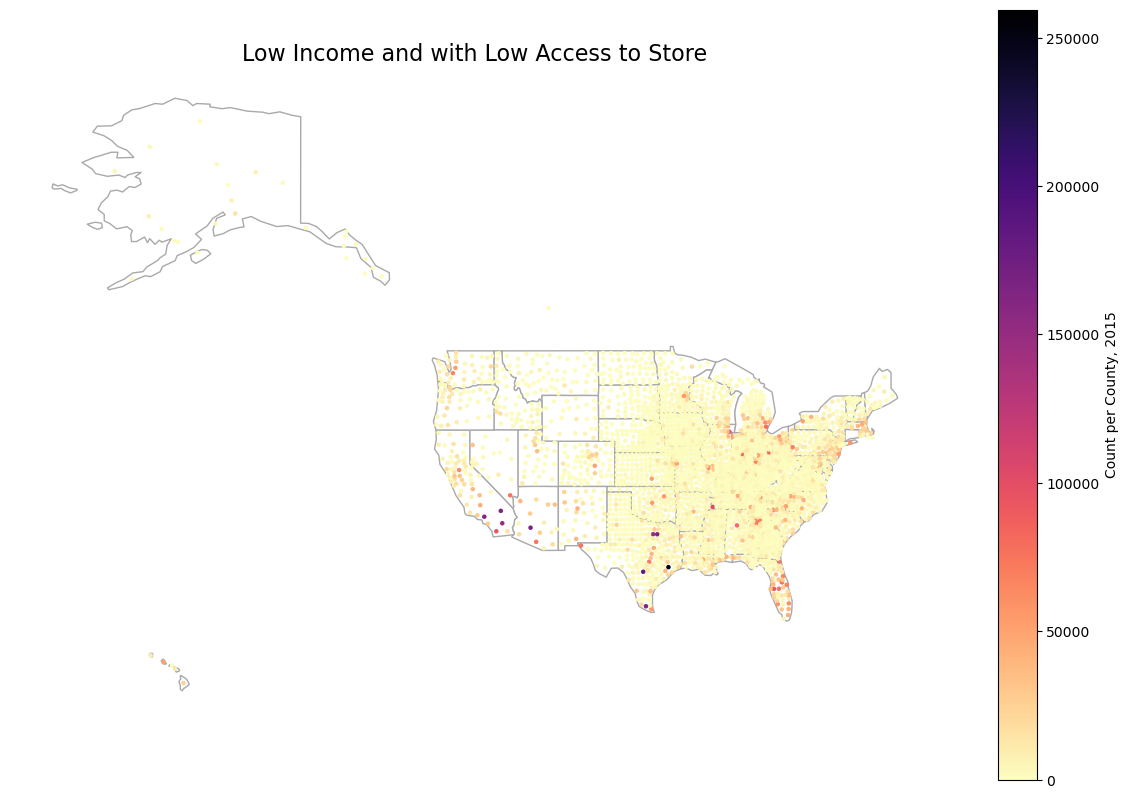

In [566]:
# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot USA boundaries
states.plot(ax=ax, color='white', edgecolor='darkgrey')

# Overlay the cities data
gdf.plot(column='Low income & low access to store (2015, count)', 
         cmap='magma_r', 
         legend=True, 
         legend_kwds={'label': 'Count per County, 2015', 'orientation': 'vertical'},
         ax=ax, 
         markersize=5)

# Customize the plot
ax.set_title("Low Income and with Low Access to Store", fontsize=16)
plt.axis("off")
plt.show()

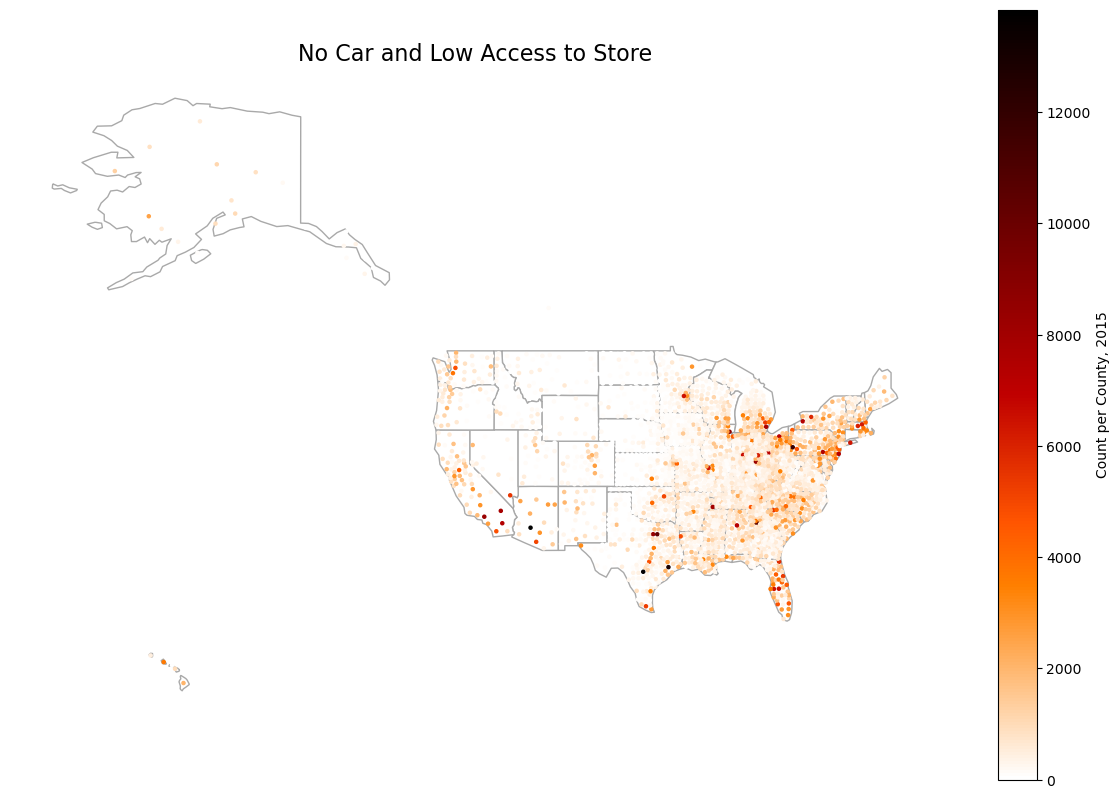

In [567]:
# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot USA boundaries
states.plot(ax=ax, color='white', edgecolor='darkgrey')

# Overlay the cities data
gdf.plot(column='Households with no car & low access to store, (2015, count)', 
         cmap='gist_heat_r', 
         legend=True, 
         legend_kwds={'label': 'Count per County, 2015', 'orientation': 'vertical'},
         ax=ax, 
         markersize=5)

# Customize the plot
ax.set_title("No Car and Low Access to Store", fontsize=16)
plt.axis("off")
plt.show()